In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Notebook

In the Model learning step, the prepared dataset from [3_Imputing](https://raw.githubusercontent.com/Rudinius/Bike_usage_Bremen/main/3_Imputing.ipynb) is loaded. Then different machine learning algorithms are trained and compared to each other.

We will test
* XGBoost
* Multilayer perceptron (MLP)
* Recurrent Neural Network (RNN)

<a name="content"></a>
# Content

* [1. Import libraries and mount drive](#1.)
* [2. Import datasets](#2.)
* [3. Select a target station](#3.)
* [4. Establish baseline benchmark](#4.)
* [5. Training machine learning algorithms](#5)
    * [5.2. XGBoost](#5.2.)
    * [5.3. Multilayer perceptron](#5.3.)
    * [5.4. Recurrent Neural Network](#5.4.)

<a name="1."></a>
# 1.&nbsp;Import libraries
[Content](#content)

In [10]:
# Import libraries
import numpy as np
import pandas as pd
import plotly.express as px
#from plotly.subplots import make_subplots
#import random
from tensorflow import keras
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, TimeSeriesSplit
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization, LSTM, Bidirectional, Reshape
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError

In [11]:
# Install package pyjanitor since it is not part of the standard packages
# of Google Colab
"""
import importlib

# Check if package is installed
package_name =["pyjanitor", "shap"]

for package in package_name:
    print(package)
    spec = importlib.util.find_spec(package)
    if spec is None:
        # Package is not installed, install it via pip
        !pip install package
    else:
        print(f"{package} is already installed")
        import package
"""


'\nimport importlib\n\n# Check if package is installed\npackage_name =["pyjanitor", "shap"]\n\nfor package in package_name:\n    print(package)\n    spec = importlib.util.find_spec(package)\n    if spec is None:\n        # Package is not installed, install it via pip\n        !pip install package\n    else:\n        print(f"{package} is already installed")\n        import package\n'

In [12]:
!pip install shap

In [27]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [13]:
keras.utils.set_random_seed(1)

<a name="2."></a>
#2.&nbsp;Import dataset
[Content](#content)

Import the processed dataset.

In [14]:
# Set base url
url = "https://raw.githubusercontent.com/Rudinius/Bike_usage_Bremen/main/data/"

In [15]:
# Import dataset

# We will also parse the date column as datetime64 and set it to the index column
df = pd.read_csv(url + "03_training_data/" + "2023-08-24_processed_df.csv",
                         parse_dates=[0], index_col=[0])

# Check the correct loading of dataset
df.head()

,graf_moltke_straße_ostseite,graf_moltke_straße_westseite,hastedter_bruckenstraße,langemarckstraße_ostseite,langemarckstraße_westseite,osterdeich,radweg_kleine_weser,schwachhauser_ring,wachmannstraße_auswarts_sud,wachmannstraße_einwarts_nord,...,holiday_2_weihnachtsfeiertag,holiday_christi_himmelfahrt,holiday_karfreitag,holiday_neujahr,holiday_ostermontag,holiday_pfingstmontag,holiday_reformationstag,holiday_tag_der_arbeit,holiday_tag_der_deutschen_einheit,transformed_vacation
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,261.0,290.0,381.0,312.0,308.0,870.0,410.0,391,514.0,267.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2013-01-02,750.0,876.0,1109.0,1258.0,1120.0,2169.0,1762.0,829,1786.0,1456.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2013-01-03,931.0,1015.0,1603.0,1556.0,1480.0,2295.0,2287.0,1196,2412.0,2035.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2013-01-04,500.0,587.0,1284.0,703.0,626.0,1640.0,1548.0,1418,964.0,702.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2013-01-05,1013.0,1011.0,0.0,1856.0,1621.0,4128.0,4256.0,3075,2065.0,1377.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


<a name="3."></a>
# 3.&nbsp;Select a target station
[Content](#content)


There are many stations that we could train our model on. Also we could add up all stations to a column `total` and try to predict the overall number in the city per day. However this approach would average many values which would lead on side to less noisy data as single outliers would be less impactful. On the other side it would also average over indivdual patterns.

For this reason, we choose a single station to train our model on. For real-life purposes better results could be expected with one model per station.

For the further process, we will work with the station: `wilhelm_kaisen_brucke_ost`


In [16]:
target = "imputed_wilhelm_kaisen_brucke_ost"

<a name="4."></a>
# 4.&nbsp;Establish baseline benchmark
[Content](#content)


For our current task of creating model a to predict the amount of cyclers for a given day, we do not have any baseline metric score to measure our model against.
For this reason, we will create a naive baseline model. For this, we will simply predict the amount of a day based on the value of previous day.

In [17]:
# Evaluate the model's performance using RMSE

# Select the `wilhelm_kaisen_brucke_ost` column as our target and preds arrays
y = y_hat = df.loc[:,target]

rmse = 0
length = y.shape[0]

# Loop from 0 to second last entry, as we can only use seconds last entry to
# predict the last entry of series
for i in range(length-1):
    # The mean_sqared_error function expects an array as input, therfore we
    # concatenate the range from current value to current value + 1 (excluding)
    rmse += np.sqrt(mean_squared_error(y[i+1:i+2], y_hat[i:i+1]))

# Divide rmse value by number of pairs
rmse = rmse / (length-1)
print("RMSE: %f" % (rmse))

RMSE: 1791.993974


If we were naivly predicting the current value with the last value, we get an error over the entire dataset of approximately $1,792$.

This is our naive benchmark to compare our model against.

Another method would be to predict the value of a given day by the average of all the other equal days in the dataset (e.g., to predict 18.08.2017, we take the average of all other 18.08. days in the dataset).

In [18]:
# Initialize squared error
se = 0

# Get the total number of examples
m = df.shape[0]

for i in df.index:
    day = i.day
    month = i.month
    year = i.year

    # create a mask for given day but exclude the day we want to predict
    mask = (df.index.day == day) & (df.index.month == month) & (df.index.year != year)

    # Get value for current day and mean values of all the other same days in the dataset
    y = df.loc[i, target]
    y_hat = df.loc[mask, target].mean()

    # Calculate the squared error
    se += (y - y_hat)**2

# Calculate mean squared error
mse = se / m

# Calcualte root mean squared error
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 2033.3351259991568


With this second approach, of average all our previous values for the given day and using this as our forecast, we get an error over the entire dataset of approximately $2,033$.

The error of this second naive approach is close to the first approach.
Both approaches could be seen as human-level as this would be a typical approach of a human, to predict the value of any given day. A domain expert, who also looks at more data and e.g., compares also the temperatures, could come up with better estimates. However humans are typically not very good in accurately predicting complex time-series data. The expected Bayes error (least possible error) should therefore be much lower.

<a name="5"></a>
# 5.&nbsp;Training machine learning algorithms
[Content](#content)

We are going to train 1 shallow machine learning algorithm and 2 deep machine learning algorithms to be able to compare performances. Those are:

* XGBoost
* Multilayer Perceptron (MLP -- standard NN)
* Recurrent Neural Network (RNN)

<a name="5.1."></a>
## 5.1. Adding sequential data to our model

[Content](#content)

In contrast to RNNs where the algorithm takes automically the datapoints of previous timesteps into account, XGBoost and MLPs do not have direct access to the sequential data of previous time steps.
Those algorithms have only indirect knowledge via the learned model parameters. RNNs however directly include the previous timestep for learning the parameters of the current timestep.

We will add the data points of the previous time steps as features to the feature vector.

In this case, we will only add the last 3 values, as the observed improvement of accuracy (RMSE score) is drastically decressing with each further time step added after 3 steps.

Improvements:
* 1 day 6291 2,8%
* 2 day 6157 2,1%
* 3 day 6120 0,6%

The following code creates a dataframe with a variable amount of time:

In [19]:
"""
# Create empty new dataframe
df_lagged_days = pd.DataFrame({})

# Select the number of lagged days
go_back_x_days = 3

for i in range(go_back_x_days):
    # Shift the values in "Total" by i and assign to new column prev_Total_i+1
    df_lagged_days[f'prev_total_{i+1}'] = df_transformed_date['total'].shift(i+1)
"""

'\n# Create empty new dataframe\ndf_lagged_days = pd.DataFrame({})\n\n# Select the number of lagged days\ngo_back_x_days = 3\n\nfor i in range(go_back_x_days):\n    # Shift the values in "Total" by i and assign to new column prev_Total_i+1\n    df_lagged_days[f\'prev_total_{i+1}\'] = df_transformed_date[\'total\'].shift(i+1)\n'

<a name="5.2."></a>
## 5.2. XGBoost
[Content](#content)

For XGBoost, we will add the dataframe `df_lagged_days` to our dataset. Because we do not have all the information about the previous days for the first `go_back_x_days`, we drop the rows with `na` values. The parameter on how far to go back in time, has therefore an impact on the length of our dataset.

In [20]:
"""
# Concat new dataframe with old dataframe
# Using bfill strategy on dataset since the first few days will have NaN values
# Using pyjanitor to clean up names
df_transformed_date_lagged = (pd.concat([df_transformed_date, df_lagged_days], axis=1)
                              .dropna(axis=0)
                              .clean_names(strip_underscores="both"))

# Check output
df_transformed_date_lagged
"""

'\n# Concat new dataframe with old dataframe\n# Using bfill strategy on dataset since the first few days will have NaN values\n# Using pyjanitor to clean up names\ndf_transformed_date_lagged = (pd.concat([df_transformed_date, df_lagged_days], axis=1)\n                              .dropna(axis=0)\n                              .clean_names(strip_underscores="both"))\n\n# Check output\ndf_transformed_date_lagged\n'

<a name="5.2.1"></a>
### 5.2.1 Split data into train and dev set and standardize training data
[Content](#content)

Now, we will split the data into a training set and into a dev set. Also here we select the final futures, which we want to use to train our model.

Highly correlated features `tavg`, `tmin`, `wpgt` will be removed and features with no correlation to our target value will be also removed (`wdir`).

When splitting into train and dev set, we will not shuffle the data. This ensures that the validation results are more realistic since they are being evaluated on the data collected after the model was trained. Otherwise we would introduce a "leakage error" into our data.

In [21]:
features_date = [
    'year',
    'month',
    'day',
    'weekday',
]

features_sin_cos_transformation = [
    'week_sin', 'week_cos',
    'month_sin', 'month_cos',
    'year_sin', 'year_cos',
]

features_weather = [
    'tmax',
    'prcp',
    'imputed_snow',
    'wspd',
    'pres',
    'tsun',
    ]

features_holidays_vacation = [
    'holiday_1_weihnachtsfeiertag', 'holiday_2_weihnachtsfeiertag',
    'holiday_christi_himmelfahrt', 'holiday_karfreitag', 'holiday_neujahr',
    'holiday_ostermontag', 'holiday_pfingstmontag',
    'holiday_reformationstag', 'holiday_tag_der_arbeit',
    'holiday_tag_der_deutschen_einheit', 'transformed_vacation'
    ]

# Target is 'imputed_wilhelm_kaisen_brucke_ost'
target = target

# Higly correlated features have been removed (tavg, tmin, imputed_wpgt)
# Features with no correlation have been removed (imputed_wdir, wdir_sin, wdir_cos)
# Only all single couting stations are being removed

In [22]:
features = features_sin_cos_transformation + features_weather + features_holidays_vacation
features

['week_sin',
 'week_cos',
 'month_sin',
 'month_cos',
 'year_sin',
 'year_cos',
 'tmax',
 'prcp',
 'imputed_snow',
 'wspd',
 'pres',
 'tsun',
 'holiday_1_weihnachtsfeiertag',
 'holiday_2_weihnachtsfeiertag',
 'holiday_christi_himmelfahrt',
 'holiday_karfreitag',
 'holiday_neujahr',
 'holiday_ostermontag',
 'holiday_pfingstmontag',
 'holiday_reformationstag',
 'holiday_tag_der_arbeit',
 'holiday_tag_der_deutschen_einheit',
 'transformed_vacation']

In [23]:
# Split the data into training and dev sets
# We set shuffle to False
X_train, X_dev, y_train, y_dev = train_test_split(df[features], df[target],
                                                    test_size=0.2, shuffle=False, random_state=0)

print("X_train: ", X_train[features].shape, "y_train: ", y_train.shape)
print("X_dev: ", X_dev[features].shape, "y_dev: ", y_dev.shape)

X_train:  (2921, 23) y_train:  (2921,)
X_dev:  (731, 23) y_dev:  (731,)


Finally, we will standardize our dataset. Standarization will generally improve learning speed of the models and can help to improve the accuarcy of the model.

In [24]:
# Standardize and fit to the training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same standardization to the dev set
X_dev_scaled = scaler.transform(X_dev)

#X_train_scaled = X_train
#X_dev_scaled = X_dev

<a name="5.2.2"></a>
### 5.2.2 Using GridSeachCV to select the optimal parameters
[Content](#content)

We will use `GridSearchCV` to select optimal parameters among the preselected ranges for the training data. Furthermore we will create our own scoring metric, to evaluate the performance of the parameters found with `GridSearchCV`.

`GridSearchCV` is using `KFold` for regression problems as default. However `KFold` would split the training data in such a way, that later data will be evaluated against earlier data, introducing `leackage error`.
Therefore we do not use the default, but create splits with `TimeSeriesSplit` and pass this to `GridSearchCV`.

In [25]:
# Create custom function for evaluating GridSearchCV
def custom_rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

# Create the scoring object using the custom scoring function
custom_scorer_rmse = make_scorer(custom_rmse)

In [ ]:
params = {
    'n_estimators': [1000],
    'learning_rate': [0.05],
    'max_depth': [5, 10, 20],           # max. depth of tree
    'min_child_weight': [3, 6, 12],     # min. weight for splitting into new node
    'colsample_bytree': [0.7, 0.8],     # subsample ratio of columns
    'reg_alpha': [2.0, 4.0, 8.0],       # L1 regularization
    'reg_lambda': [4.0, 8.0, 16.0],    # L2 regularization
}

# Getting time series splits using TimeSeriesSplit
n = 4
tscv = TimeSeriesSplit(n_splits=n)
splits = []

for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    splits.append((train_index, test_index))

# Define the estimator
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=0)

# Define GridSearch and fit GridSearch on the training data with the custom scorer and custom splits
grid_search = GridSearchCV(xg_reg, param_grid=params, cv=splits, scoring=custom_scorer_rmse, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and score as well as the best model to that score
print(grid_search.best_params_)
print(grid_search.best_score_)

best_model = grid_search.best_estimator_
print(best_model)

Fitting 4 folds for each of 162 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 12, 'n_estimators': 1000, 'reg_alpha': 8.0, 'reg_lambda': 8.0}
7136.89129076001
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=12, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)


{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 1000, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 1.0}


{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 5, 'n_estimators': 1000, 'reg_alpha': 7.0, 'reg_lambda': 4.0, 'subsample': 1.0}


{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 12, 'n_estimators': 1000, 'reg_alpha': 8.0, 'reg_lambda': 8.0}


In [29]:
# Build the XGBoost regressor model with selected hyper parameters
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',  reg_alpha = 10.0, reg_lambda = 1.0, learning_rate = 0.1)

""", colsample_bytree = 0.5, learning_rate = 0.05,
                          max_depth = 8, n_estimators = 1000, reg_alpha = 10.0, reg_lambda = 40.0,
                          subsample = 0.8, min_child_weight=5"""

xg_reg.fit(X_train_scaled, y_train)

# Predict on the train set
y_train_hat = xg_reg.predict(X_train_scaled)

# Predict on the dev set
y_dev_hat = xg_reg.predict(X_dev_scaled)

# Evaluate the model's performance using RMSE
# Training set
rmse_train = custom_rmse(y_train, y_train_hat)
print("Train RMSE: %f" % (rmse_train))

# Dev set
rmse_dev = custom_rmse(y_dev, y_dev_hat)
print("Dev RMSE: %f" % (rmse_dev))

Train RMSE: 820.721704
Dev RMSE: 1473.750005


sin and cos
Train RMSE: 1019.252085
Dev RMSE: 1709.549721

date
Train RMSE: 1184.215359
Dev RMSE: 1761.530727

To get an understanding of our model and also to check for plausibility (e.g., did the model pick up correct patterns) we plot the feature importance with the `shap` library.

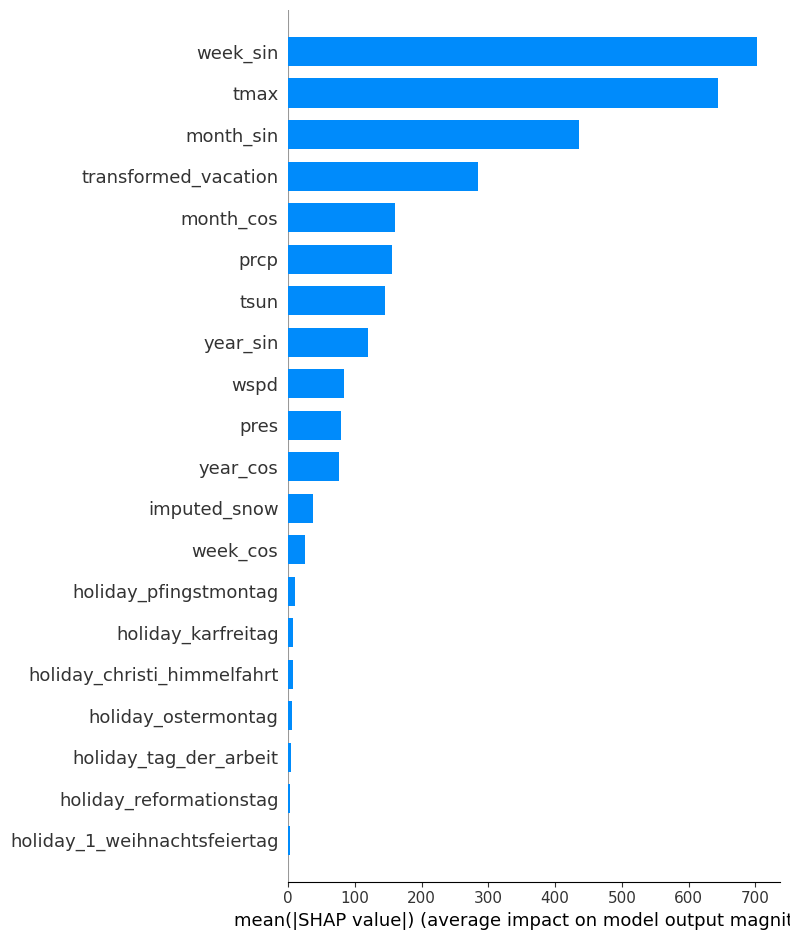

In [56]:
def plot_shap(model, features, explainer_method, df=None):
    # DF, based on which importance is checked
    X_importance = X_train_scaled

    # Explain model predictions using shap library:
    explainer = explainer_method(model, df)
    shap_values = explainer.shap_values(X_importance)

    # Plot summary_plot as barplot:
    shap.summary_plot(shap_values, X_importance, feature_names=features, plot_type='bar')

plot_shap(xg_reg, features, shap.TreeExplainer)

This plot tells us, that the most important features for the model output are `week_sin`, `tmax`, `month_sin`, and `transformed_vacation`. This seems reasonable since we have seen a weekly periodicity and `tmax` having the highest correlation.

<a name="5.3."></a>
## 5.3. Multilayer Perceptron
[Content](#content)

In [52]:
dropout = 0.2 # 0.2 best

# Define the architecture of the MLP with L2 regularization
model_mlp = Sequential()

model_mlp.add(Input(shape=(len(features),)))
model_mlp.add(Dense(units=128, activation='relu'))
model_mlp.add(Dropout(dropout))
model_mlp.add(Dense(units=64, activation='relu'))
model_mlp.add(Dropout(dropout))
model_mlp.add(Dense(units=1, activation='linear'))  # Output layer with 1 neuron for regression

# Compile the model with mean squared error (MSE) loss, and root mean square error (RMSE) as metric
# Use Adam optimizer with learning rate
optimizer = Adam(learning_rate=0.01)
model_mlp.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])

print(model_mlp.summary())

# Train the model and save the learning history, use x_dev and y_dev for validation
history = model_mlp.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_dev_scaled, y_dev))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               3072      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11,393
Trainable params: 11,393
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
92/92 [==========================

all features with cos and sin
Epoch 100/100
92/92 [==============================] - 0s 3ms/step - loss: 2264314.0000 - root_mean_squared_error: 1504.7638 - val_loss: 2452808.2500 - val_root_mean_squared_error: 1566.1444

In [53]:
# Create the array for the x axis, starting from 1
epochs = np.arange(1, len(history.history["root_mean_squared_error"])+1)
train_rmse = history.history["root_mean_squared_error"]
dev_rmse = history.history["val_root_mean_squared_error"]

# Create a line chart with two lines using Plotly Express
fig = px.line(title='train RMSE vs. dev RMSE')
fig.add_scatter(x=epochs, y=train_rmse, mode='lines+markers', name='Train RMSE', line=dict(color='red'))
fig.add_scatter(x=epochs, y=dev_rmse, mode='lines+markers', name='Dev RMSE', line=dict(color='blue'))


# Set chart title and axis labels
fig.update_layout(
    xaxis_title='Epochs',
    yaxis_title='RMSE'
)

# Show the chart
fig.show()

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:107: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

/usr/local/lib/python3.10/dist-packages/keras/backend.py:452: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



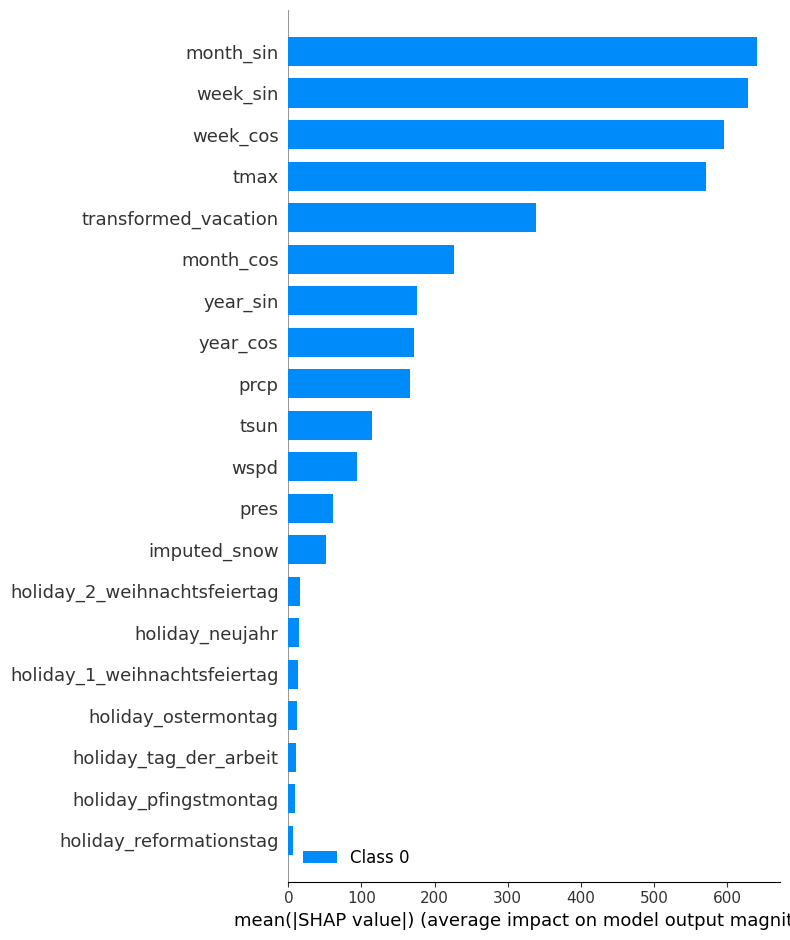

In [58]:
plot_shap(model_mlp, features, shap.DeepExplainer, X_train_scaled)

In [ ]:
preds_train = model.predict(X_train_scaled)

# Evaluate the model's performance using RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
print("Trai RMSE: %f" % (rmse_train))

preds_dev = model.predict(x_dev_scaled)

# Evaluate the model's performance using RMSE
rmse_dev = np.sqrt(mean_squared_error(y_dev, preds_dev))
print("Dev RMSE: %f" % (rmse_dev))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



92/92 [==============================] - 1s 10ms/step
Trai RMSE: 2623.097985
23/23 [==============================] - 0s 8ms/step
Test RMSE: 8387.871121


<a name="5.4."></a>
## 5.4. Recurrent Neural Network
[Content](#content)

Lastly, we train an RNN to compare to the previous two models. A RNN can take in multiple timesteps, to make a prediction (Many-to-One). Specifically, we will feed in 4 timesteps at a time (current day and the 3 previous days) and output the prediction of the current day.

Out input shape is therefore (none, 4, 21), where none represents a variable amount of training days (in our case the length of X_train).

In [ ]:
"""
# Load the data into a pandas dataframe
data = df_transformed_date

# Define the features and target
# Higly correlated features have been removed (tavg, tmin, wpgt)
# Features with no correlation have been removed (wdir)
# Only all single couting stations are being removed
features = [feature for feature in data.columns if feature not in ["tavg", "tmin", "wpgt", "wdir",
                                                                    'graf_moltke_straße_ostseite', 'graf_moltke_straße_westseite',
                                                                    'hastedter_bruckenstraße', 'langemarckstraße_ostseite',
                                                                    'langemarckstraße_westseite', 'osterdeich', 'radweg_kleine_weser',
                                                                    'schwachhauser_ring', 'wachmannstraße_auswarts_sud',
                                                                    'wachmannstraße_einwarts_nord', 'wilhelm_kaisen_brucke_ost',
                                                                    'wilhelm_kaisen_brucke_west', 'total']]
target = ['total']

print(features)

# Split the data into training and dev sets
X_train, X_dev, y_train, y_dev = train_test_split(data[features], data[target],
                                                    test_size=0.2, shuffle=False, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)"""

['year', 'month', 'day', 'weekday', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'tsun', 'vacation', 'holiday_1_weihnachtsfeiertag', 'holiday_2_weihnachtsfeiertag', 'holiday_christi_himmelfahrt', 'holiday_karfreitag', 'holiday_neujahr', 'holiday_ostermontag', 'holiday_pfingstmontag', 'holiday_reformationstag', 'holiday_tag_der_arbeit', 'holiday_tag_der_deutschen_einheit']
(2921, 21)
(2921, 1)
(731, 21)
(731, 1)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from keras.utils import timeseries_dataset_from_array

input_data = X_train
#targets = y_train[3:]
targets = y_train
dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=input_data, targets=targets, sequence_length=4, batch_size=None, shuffle=False)


#print(dataset.take(10))

for x,y in dataset.take(1):
    print(x, y)
"""

#for x, y in dataset.take(10):
#    print(x, y)

y_trainnnn = tf.keras.utils.timeseries_dataset_from_array(
    data=targets, targets=None, sequence_length=4, batch_size=None, shuffle=False)


for y in y_trainnnn.take(10):
    print(y)

x_trainnnn.to_numpy()"""


tf.Tensor(
[[ 7.81831482e-01  6.23489802e-01  2.01298520e-01  9.79529941e-01
   1.72133562e-02  9.99851839e-01  9.10000000e+00  6.90000000e+00
   0.00000000e+00  1.94000000e+01  1.00180000e+03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 9.74927912e-01 -2.22520934e-01  3.94355855e-01  9.18957812e-01
   3.44216116e-02  9.99407401e-01  7.10000000e+00  1.80000000e+00
   0.00000000e+00  2.02000000e+01  1.01750000e+03  3.00000000e+01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 4.33883739e-01 -9.00968868e-01  5.71268215e-01  8.20763441e-01
   5.16196672e-02  9.98666816e-01  1.06000000e+01  9.00000000e-01
   0.00000000e+00  2.38000000e+01  1.02450000e+03  0.00000000e+00
   0.00000000e+00  0.00000000

'\n\n#for x, y in dataset.take(10):\n#    print(x, y)\n\ny_trainnnn = tf.keras.utils.timeseries_dataset_from_array(\n    data=targets, targets=None, sequence_length=4, batch_size=None, shuffle=False)\n\n\nfor y in y_trainnnn.take(10):\n    print(y)\n\nx_trainnnn.to_numpy()'

In [ ]:
# Standardize and fit to the training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same standardization to the dev set
X_dev_scaled = scaler.transform(X_dev)

#X_train_scaled = X_train
#_dev_scaled = X_dev

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# Define the number of timesteps
timesteps = 4

# Step 1: Create sequences of length 4
X_train_scaled_3d, X_dev_scaled_3d = [], []
y_train_3d, y_dev_3d = [], []

for i in range(len(X_train_scaled) - timesteps + 1):
    X_train_scaled_3d.append(X_train_scaled[i : i + timesteps])
    y_train_3d.append(y_train[i : i + timesteps])

X_train_scaled_3d = np.array(X_train_scaled_3d)
#y_train = y_train [timesteps-1:]
y_train_3d = np.array(y_train_3d)
#y_train_3d = np.expand_dims(y_train_3d, axis=2)

for i in range(len(X_dev_scaled) - timesteps + 1):
    X_dev_scaled_3d.append(X_dev_scaled[i : i + timesteps])
    y_dev_3d.append(y_dev[i : i + timesteps])

X_dev_scaled_3d = np.array(X_dev_scaled_3d)
#y_dev = y_dev [timesteps-1:]
y_dev_3d = np.array(y_dev_3d)
#y_dev_3d = np.expand_dims(y_dev_3d, axis=2)

print(X_train_scaled_3d.shape)
#print(y_train.shape)
print(y_train_3d.shape)

print(X_dev_scaled_3d.shape)
#print(y_dev.shape)
print(y_dev_3d.shape)

(2918, 4, 23)
(2918, 4)
(728, 4, 23)
(728, 4)


In [ ]:
print(X_train_scaled_3d.shape)
X_train_scaled_3d[0]

(2921, 1, 23)


array([[ 1.10461413,  0.8817232 ,  0.28024778,  1.42493607,  0.02433919,
         1.41327836, -0.71259085,  1.45245197, -0.13112669,  0.67096715,
        -1.40081458, -1.06115073, -0.05240524, -0.05240524, -0.05240524,
        -0.05240524, 19.08205964, -0.05240524, -0.05240524, -0.03703069,
        -0.05240524, -0.05240524,  1.73086569]])

In [ ]:
print(y_train_3d.shape)
y_train_3d[0]

(2921, 1)


array([1228.])

In [ ]:
testing_y = np.expand_dims(y_train_3d,axis=2)
print(testing_y.shape)
testing_y[0:2]

In [ ]:
print(X_train_scaled_3d[0:2])
print(y_train_3d[0:2])

In [40]:
"""
Simple bidrectional LSTM model

"""


num_sequence = 4
# Build the LSTM model
"""
model = Sequential()
model.add(LSTM(units=256, input_shape=(1, X_train.shape[1]), activation='relu'))
# Add a dense output layer with a single unit (for regression) and no activation function
model.add(Dense(units=1))
"""
"""
model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
"""
# Build the LSTM model
"""
model = Sequential()
model.add(Input(shape=(num_sequence, 21)))
model.add(LSTM(units=32, activation='relu', dropout=0.1))
model.add(Dense(units=1, activation='linear'))

model = Sequential([
    #Input(shape=(num_sequence, 21)),
    # Shape [batch, time, features] => [batch, time, lstm_units]
    LSTM(32, activation='relu', dropout=0.1, return_sequences=True),
    # Shape => [batch, time, features]
    Dense(units=1, activation='linear')
])"""

CONV_WIDTH = 3


"""OUT_STEPS = 4
model = tf.keras.Sequential(
    [
        Input(shape=(num_sequence, 23)),
        tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
        tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(32, return_sequences=True)
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(32, return_sequences=False)
        ),
        tf.keras.layers.Dense(
            OUT_STEPS * 1, kernel_initializer=tf.initializers.zeros()
        ),
        tf.keras.layers.Reshape([OUT_STEPS, 1]),
    ]
)
"""

inputs = Input(shape=(num_sequence, 23))
#x = tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :])(inputs)
#x = tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH))(x)
x = Bidirectional(LSTM(64, activation='relu', dropout=0.25, return_sequences=True))(inputs)
x = Bidirectional(LSTM(32, activation='relu', dropout=0.25, return_sequences=True))(x)
#x = LSTM(64, activation='relu', dropout=0.2, return_sequences=True)(inputs)
#x = LSTM(32, activation='relu', dropout=0.2, return_sequences=True)(x)
#x = LSTM(32, activation='relu', dropout=0.0, return_sequences=True)(x)
outputs = Dense(1, activation='linear')(x)
#outputs = Reshape([num_sequence, 1])(x)

"""
inputs = Input(shape=(num_sequence, 21))
x = LSTM(64, activation='relu', dropout=0.1, return_sequences=True)(inputs)
outputs = Dense(1, activation='linear', name="custom_output")(x)
"""

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])

print(model.summary())




#X_train_scaled_3d = np.reshape(X_train_scaled, (num_samples, num_sequence, X_train_scaled.shape[1]))  # Fix variable name

#num_samples = X_dev_scaled.shape[0]
#X_dev_scaled_3d = np.reshape(X_dev_scaled, (num_samples, num_sequence, X_dev_scaled.shape[1]))

# Train the model
#X_train_scaled_3d = np.expand_dims(X_train_scaled_3d[0], axis=0)
#y_train_3d = np.expand_dims(y_train_3d[0], axis=0)
#print(X_train_scaled_3d)
#print(y_train_3d)
#print(testing_y.shape)

#X = X_train_scaled_3d.reshape((X_train_scaled_3d.shape[0], 2, 1, 2, 23))
#Xdev = X_dev_scaled_3d.reshape((X_dev_scaled_3d.shape[0], 2, 1, 2, 23))


#history = model.fit(X_train_scaled_3d, testing_y, epochs=10, batch_size=32, verbose=2, validation_data=(X_dev_scaled_3d, y_dev_3d))
#history = model.fit(X, y_train_3d, epochs=50, batch_size=32, validation_data=(Xdev, y_dev_3d))

history = model.fit(X_train_scaled_3d, y_train_3d, epochs=20, batch_size=32, validation_data=(X_dev_scaled_3d, y_dev_3d))
#history = model.fit(dataset, epochs=10, batch_size=32, verbose=2, validation_data=(X_dev_scaled_3d, y_dev_3d))
#history = model.fit(x_trainnnn, y_trainnnn, epochs=10, batch_size=32, verbose=2)

#validation_data=(X_dev_scaled, y_dev)

#output = model.predict(X_train_scaled_3d)
#output = model.predict(X_train_scaled_3d)
#intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("custom_output").output)
#intermediate_model.predict(X_train_scaled_3d)




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 23)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 4, 128)           45056     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 64)            41216     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 4, 1)              65        
                                                                 
Total params: 86,337
Trainable params: 86,337
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
92/92 [==============================] - 

In [59]:
plot_shap(model, features, shap.DeepExplainer, X_train_scaled)

AssertionError: ignored

In [62]:
explainer = shap.DeepExplainer(model, X_train_scaled)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:107: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



AssertionError: ignored

In [ ]:
"""
Complex model takes very long and val score is not much better. It overfitted
Epoch 50/50
92/92 [==============================] - 25s 273ms/step - loss: 1557592.7500 - root_mean_squared_error: 1248.0355 - val_loss: 2976063.0000 - val_root_mean_squared_error: 1725.1270
"""


#num_samples = len(X_train_scaled_3d)
num_sequence = 4
# Build the LSTM model

CONV_WIDTH = 3

model = tf.keras.Sequential(
        [
            tf.keras.layers.ConvLSTM2D(filters=512, kernel_size=(1,2), activation='relu', dropout=0.2, input_shape=(2, 1, 2, 23)),
            tf.keras.layers.Dense(
                num_sequence, kernel_initializer=tf.initializers.zeros()
            ),
            tf.keras.layers.Reshape([num_sequence, 1]),
        ]
    )

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])

print(model.summary())

X = X_train_scaled_3d.reshape((X_train_scaled_3d.shape[0], 2, 1, 2, 23))
Xdev = X_dev_scaled_3d.reshape((X_dev_scaled_3d.shape[0], 2, 1, 2, 23))

history = model.fit(X, y_train_3d, epochs=50, batch_size=32, validation_data=(Xdev, y_dev_3d))

In [ ]:
# Create the array for the x axis, starting from 1
epochs = np.arange(1, len(history.history["root_mean_squared_error"])+1)
train_rmse = history.history["root_mean_squared_error"]
dev_rmse = history.history["val_root_mean_squared_error"]

# Create a line chart with two lines using Plotly Express
fig = px.line(title='train RMSE vs. dev RMSE')
fig.add_scatter(x=epochs, y=train_rmse, mode='lines+markers', name='Train RMSE', line=dict(color='red'))
fig.add_scatter(x=epochs, y=dev_rmse, mode='lines+markers', name='Dev RMSE', line=dict(color='blue'))


# Set chart title and axis labels
fig.update_layout(
    xaxis_title='Epochs',
    yaxis_title='RMSE'
)

# Show the chart
fig.show()

<a name="6."></a>
## 6. Summary and conclusion
[Content](#content)

We have trained three different models with increasing complexity. For the problem at hand it can be said that the more complex MLP model or LSTM model did not perform better, than the simpler XGBoost model. In fact, the LSTM model performt worse than the two previous ones.

While the XGBoost model already did well with standard parameters, it was more difficult to find a good architecture with the more complex model MLP and LSTM which was especially true for the last model.

A possible reason, why the LSTM model performed worse could be, that the problem at hand has not a strong sequential nature. The dataset is clearly time series data, but the different data points or not very dependent on the previous data points. An easy ilustration to this is, that the people taking a bycicle today, do not care about the weather of yesterday or how many people took the bicyle one day ago. Much more relevant is the current day of the week and the weather of today. Therefore the sequential LSTM model mostly added complexity without adding much of value.